In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from matplotlib_venn import venn2, venn2_unweighted

import networkx as nx
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod

# personal modules
import databases as db
import kuzmin_data_2018 as data_2018
import kuzmin_data_2020 as data_2020
import enrichment as enrich


In [2]:
dataset = "Kuzmin2020" # Kuzmin2020 or Kuzmin2018

In [3]:
if dataset == "Kuzmin2018":
    kuzmin_2018_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2018/data_files"
    kuzmin_2018_s1, kuzmin_2018_s1_digenic, kuzmin_2018_s1_trigenic = data_2018.load_kuzmin_2018_s1(kuzmin_2018_data_dir)

    costanzo_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"
    costanzo_data = data_2018.load_costanzo_data(costanzo_et_al_data_dir)
    #kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    #kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    #kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


    #print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    #print(kuzmin_2020_s2.combined_mutant_type.value_counts())


    # f_i and f_j taken from costanzo, f_k taken from array allele in kuzmin 2018

    f_k_SMF = dict(zip(kuzmin_2018_s1_trigenic.array_allele_name, kuzmin_2018_s1_trigenic.array_single_mutant_fitness))

    s1 = pd.concat([costanzo_data.query_allele_name, costanzo_data.array_allele_name], axis=0)
    s2 = pd.concat([costanzo_data.query_smf, costanzo_data.array_smf], axis=0)
    df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
    df = df.drop_duplicates(subset=["allele"], keep='first').reset_index(drop=True)
    f_i_j_SMF = dict(zip(df.allele, df.value))

    # f_ij from query fitness in trigenic table
    # f_ik and f_jk from fitness digenic table
    f_ij_DMF = dict(zip(kuzmin_2018_s1_trigenic.query_allele_name, kuzmin_2018_s1_trigenic.query_single_double_mutant_fitness))
    f_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness))

    #e_ik and e_jk come from the digenic portion of the Kuzmin 2018 S1 table
    e_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.raw_interaction_score_epsilon))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2018.consolidate_fitnesses_across_2018_tables(kuzmin_2018_s1_trigenic,
                                                                                                        f_k_SMF,
                                                                                                        f_i_j_SMF,
                                                                                                        f_ij_DMF,
                                                                                                        f_ik_jk_DMF,
                                                                                                        e_ik_jk_DMF)
                                                            
    df = kuzmin_2018_s1_trigenic

if dataset == "Kuzmin2020":
    kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
    kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data_2020.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
    kuzmin_2020_s3, kuzmin_2020_s3_digenic = data_2020.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data_2020.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    kuzmin_2020_s2 = data_2020.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


    print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    print(kuzmin_2020_s2.combined_mutant_type.value_counts())

    kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
    kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
    kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

    kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

    kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
    kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

    kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
    kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2020.consolidate_fitnesses_across_tables(kuzmin_2020_s1_trigenic,
                                                                                            kuzmin_2020_s1_dblMutFit,
                                                                                            kuzmin_2020_s1_singMutFit,
                                                                                            kuzmin_2020_s1_epsilon,
                                                                                            kuzmin_2020_s3_singMutFit,
                                                                                            kuzmin_2020_s5_singMutFit,
                                                                                            kuzmin_2020_s5_dblMutFit)

    # incorporate fitnesses into the data frame so that for each triplet of genes, we have all relevant fitness values in the same row to calculate interactions
    # since we will be mostly using kuzmin_2020_s1_trigenic going forwards, lets rename it to df

    df = kuzmin_2020_s1_trigenic


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64


In [4]:
names = ['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz']
vars = [f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz]
for i in range(len(names)):
    n = names[i]
    v = vars[i]
    print(n, "\t", np.sum(np.isnan(np.array([i for i in v.values()]))))

f_i 	 30434
f_j 	 2098
f_k 	 0
f_ij 	 41244
f_ik 	 11
f_jk 	 88
e_ik_kuz 	 11
e_jk_kuz 	 88


#############################################################

AFTER THIS POINT ALL CODE IS REDUNDANT WITH THE 2020 ANALYSIS

#############################################################


In [5]:
df['f_ij'] = df['alleles'].map(f_ij)
df['f_ik'] = df['alleles'].map(f_ik)
df['f_jk'] = df['alleles'].map(f_jk)

df['f_i'] = df['alleles'].map(f_i)
df['f_j'] = df['alleles'].map(f_j)
df['f_k'] = df['alleles'].map(f_k)

df['e_ik_kuz'] = df['alleles'].map(e_ik_kuz)
df['e_jk_kuz'] = df['alleles'].map(e_jk_kuz)

In [6]:
print(np.sum(~np.isnan(df.f_ij)))
print(np.sum(~np.isnan(df.f_ik)))
print(np.sum(~np.isnan(df.f_jk)))
print(np.sum(~np.isnan(df.f_i)))
print(np.sum(~np.isnan(df.f_j)))
print(np.sum(~np.isnan(df.f_k)))
print()
print(np.sum(~np.isnan(df.e_ik_kuz)))
print(np.sum(~np.isnan(df.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(df))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(df))

215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
0.7371301988234882


fraction of tau values that remain after filtering out deviants
0.9891940424632936


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


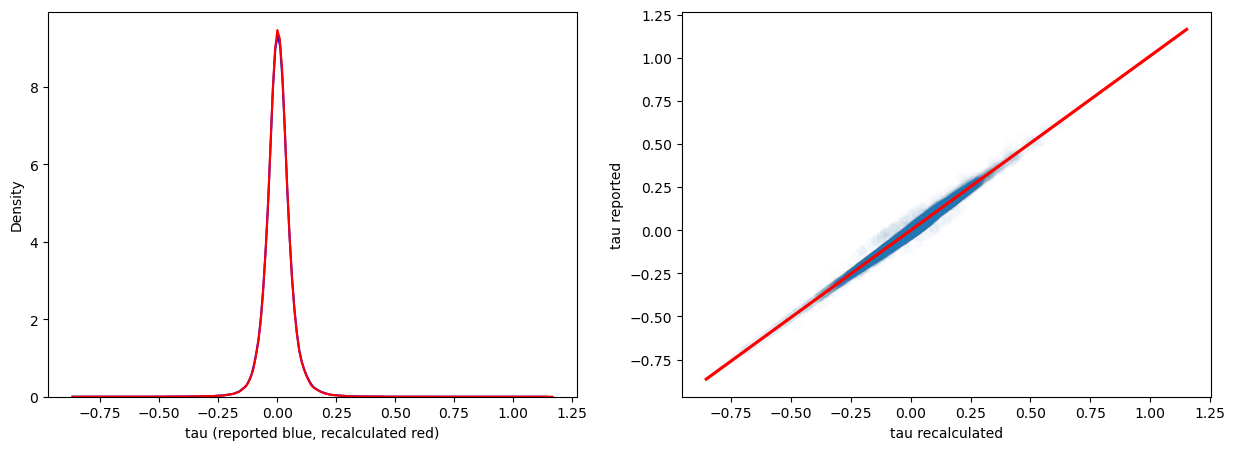

In [7]:
# To ensure we appropriately understand the data, we recalculate tau (trigenic interaction) using the formula in the supplement of Kuzmin 2018.
# These values *should* correspond to those reported in the 'adjusted_interaction_score_epsilon_or_tau' column. Around ~1% of recalculated tau values
# strongly deviate from those reported, and we filter these out.

df = df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 0.1

df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i

# filter out results that aren't reproducible according to the original equation
print("fraction of tau values that remain after filtering out deviants")
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))

df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, recalculated red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau recalculated', ylabel='tau reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")


In [8]:
df.loc[:, 'tau_cumulant'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 



# tau_cumulant (forumula from cumulant formula) calculated above should be equivalent to tau_kuzmin_orig (formula from Kuzmin et al 2018).
# One can substitute (f_jk - f_j*f_k) for e_jk and (f_ik - f_i*f_k) for e_ik into the Kuzmin et al 2018 formula to get the cumulant formula
# However, the results using these two equivalent formula aren't the same because  f_jk != (f_j*f_k + e_jk) and  f_ik != (f_i*f_k + e_ik)

# subsituting in (f_j*f_k + e_jk) for f_jk and (f_i*f_k + e_ik) for f_ik
# This gives trigenic interaction scores that are similar to reported values, see sanityChecks notebook
# newly recalculated double mutant fitnesses, and corresponding interactions, are suffixed with 2

df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:, 'tau_cumulant2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_cumulant2
#df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 

,tau_cumulant2,adjusted_interaction_score_epsilon_or_tau
tau_cumulant2,1.000000,0.997449
adjusted_interaction_score_epsilon_or_tau,0.997449,1.000000


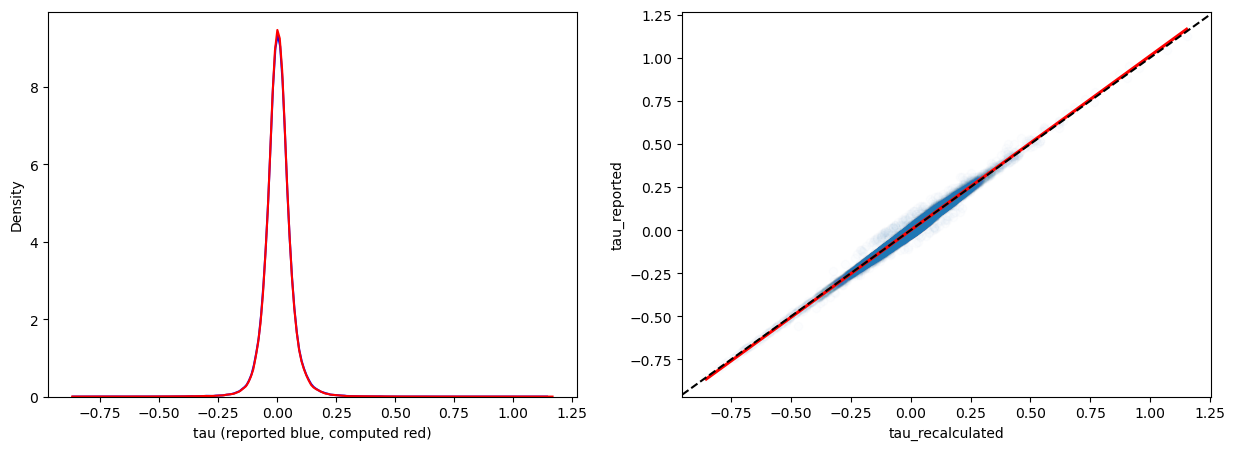

In [9]:
tau = "tau_cumulant2"

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df[tau], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df[tau],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

In [10]:
# This logical switch is used to change all downstream analyses

use_reported_double_mutant_fitnesses = False
compare_to_reported_values = True # if False, compare instead to values recalculated with cumulant formula

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    cumulant = "tau_cumulant"
else:
    multiplicative = "tau_multiplicative2"
    cumulant = "tau_cumulant2"

if compare_to_reported_values:
    compare = "adjusted_interaction_score_epsilon_or_tau"
else:
    compare = cumulant

In [11]:
# To see how outliers vary across scales, we can calculate a significance threshold for the multiplicative scale by 
# finding the quantile that corresponds +/- 0.08, the trigenic score Kuzmin et al use to find positive/negative outliers.

tau_reported_sig_quant, tau_mult_sig_val, tau_iss_sig_val = {},{},{}

# get quantiles
tau_reported_sig_quant['neg'] = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_sig_quant['pos'] = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

# calculate significance thresholds on new scales using quantile
tau_mult_sig_val['neg'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['neg'])
tau_mult_sig_val['pos'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['pos'])

tau_iss_sig_val['neg'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['neg'])
tau_iss_sig_val['pos'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['pos'])

print("quantiles of the significant values they used",  tau_reported_sig_quant['neg'], tau_reported_sig_quant['pos'] )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['neg']))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['pos']))
print()
print( "corresponding cutoffs for multiplicative model: ", tau_mult_sig_val['neg'], tau_mult_sig_val['pos'])
print( "corresponding cutoffs for cumulant model: ", tau_iss_sig_val['neg'], tau_iss_sig_val['pos'])


quantiles of the significant values they used 0.0505675568891689 0.9305530342669813
confirming (should be -0.08): -0.07998675851335334
confirming (should be 0.08): 0.07998704170448598

corresponding cutoffs for multiplicative model:  0.9051323011432824 1.1071547776828772
corresponding cutoffs for cumulant model:  -0.07906997897906276 0.07887639643511796


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.983062   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.983062  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.915095   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.915095  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplica

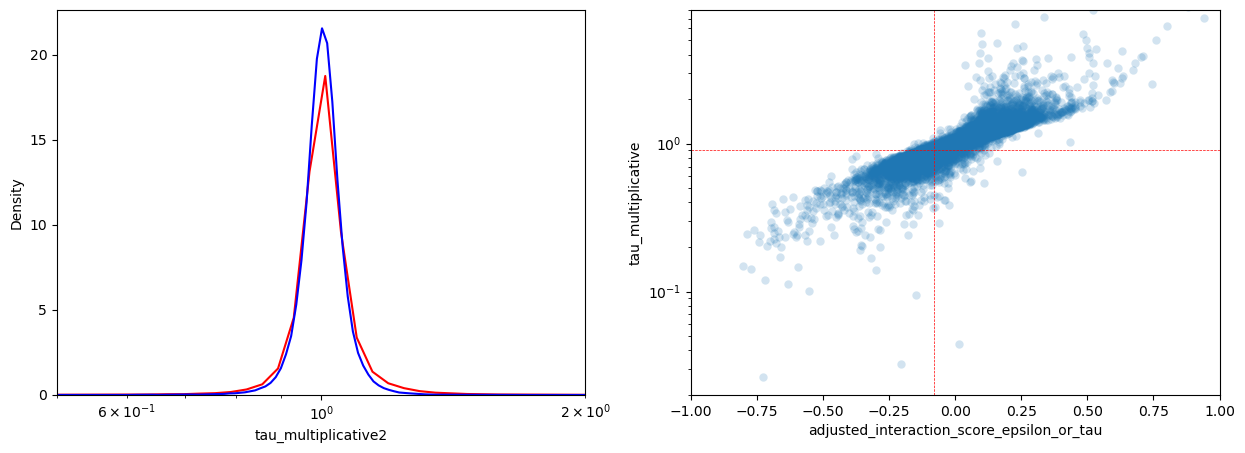

In [12]:
# How do multiplicative values compare to 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
# add one so distributions are more comparable
p = sns.kdeplot(df[compare]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.scatterplot(x=df[compare],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
p.set(xlabel=compare, ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,8)
axs[1].axhline(tau_mult_sig_val['neg'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['pos'], color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

print(df[[multiplicative, compare]].corr(method="spearman"))
print(df[[multiplicative, compare]].corr(method="kendall"))
print(df[[multiplicative, compare]].corr(method="pearson"))


In [13]:
def count_frac(df):
    return len(df)
    
results = defaultdict(list)
p = 0.05

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_reported + only_mult

results['type'].extend(['overlap', 'only reported', 'only multiplicative'])
results['number'].extend([overlap, only_reported, only_mult])
results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

#overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "positive", count_frac, multiplicative, tau_mult_sig_val)
#denom = overlap + only_reported + only_mult

#results['type'].extend(['overlap_positive', 'only reported positive', 'only mult positive'])
#results['number'].extend([overlap, only_reported, only_mult])
#results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

pd.DataFrame.from_dict(results)

,type,number,fraction
0,overlap,1527,0.729226
1,only reported,91,0.043457
2,only multiplicative,476,0.227316


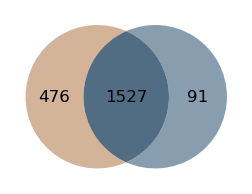

In [14]:
overlap_color = "#506D84"
only_mult_color = "#D4B499"
only_reported_color = "#889EAF"

only_mult_venn, only_reported_venn, overlap_venn = None, None, None
# copy values since similar names get used elsewhere in notebook
if not only_mult_venn and not only_reported_venn and not overlap_venn:
    only_mult_venn = only_mult
    only_reported_venn = only_reported
    overlap_venn = overlap

#plt.subplot(figsize=(15,15))
plt.figure(figsize=(3,3))
v = venn2_unweighted(subsets = (only_mult, only_reported, overlap), set_labels = ('', '', ''), set_colors=(only_mult_color, 
                                                                                            only_reported_color,
                                                                                            overlap_color), alpha = 1)
v.get_patch_by_id('11').set_color(overlap_color)
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('11').set_alpha(1)

#v = venn2(subsets = (only_mult, only_reported, overlap), set_labels = ('multiplicative', 'reported'), set_colors=('#b2df8a', '#1f78b4', '#a6cee3'), alpha = 0.7)
#out = venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(12)

print(v)
plt.show()

In [15]:
# See if outliers are enriched for other biological signals. Here we load in pairwise physical interactions from one of two databases.
# 'physical_pairwise_interactions_set' contains a set of sorted 2-tuples of genes particupating in pairwise protein interactions

#physical_pairwise_interactions_set = db.get_physical_interactions_yeastGenomeDotOrg()

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
# see here for explanation of experimental evidence codes: https://wiki.thebiogrid.org/doku.php/experimental_systems
db_interactions = db.get_physical_interactions_BIOGRID()
experimental_systems = ['Affinity Capture-MS', 'Affinity Capture-Western', 'Two-hybrid', 'Reconstituted Complex', 'PCA', 'Co-purification', 'Co-crystal Structure']
#experimental_systems = ['Affinity Capture-RNA']
#experimental_systems = ['Biochemical Activity']
#experimental_systems = ['Co-localization']
#print(db_interactions.experimental_system.value_counts())

db_interactions = db_interactions[db_interactions.experimental_system.isin(experimental_systems)]
#db_interactions = db_interactions[db_interactions.experimental_system_type == "physical"]
#db_interactions

/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [16]:
physical_pairwise_interactions_set = db.find_unique_interactions(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
num_physical_interactions, oneplus_physical_interactions, twoplus_physical_interactions, three_physical_interactions = db.count_interactions_in_set(df, physical_pairwise_interactions_set)
#df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
#df['twoplus_physical_interactions'] = df['alleles'].map(twoplus_physical_interactions)
df['three_physical_interactions'] = df['alleles'].map(three_physical_interactions)

#print()
#print(df['num_physical_interactions'].value_counts())

physical_pairwise_interactions_dict = db.collect_interactions_in_dict(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
three_shared_physical_interactions = db.count_shared_interactions_in_dict(df, physical_pairwise_interactions_dict, 1)
df['three_shared_physical_interactions'] = df['alleles'].map(three_shared_physical_interactions)

In [17]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(only_reported, only_mult))
print(test)

0.0018470935845176395


In [18]:
# arg that goes into get_coexpression_gene_pairs is the z-score associated with how significant the correlation b/t expression is
coexpression_gene_pairs_set, divexpression_gene_pairs_set = db.get_expression_gene_pairs(3)

num_coex_interactions, oneplus_coex_interactions, twoplus_coex_interactions, three_coex_interactions = db.count_interactions_in_set(df, coexpression_gene_pairs_set)
num_divex_interactions, oneplus_divex_interactions, twoplus_divex_interactions, three_divex_interactions = db.count_interactions_in_set(df, divexpression_gene_pairs_set)

df['num_coex_interactions'] = df['alleles'].map(num_coex_interactions)
df['oneplus_coex_interactions'] = df['alleles'].map(oneplus_coex_interactions)
df['twoplus_coex_interactions'] = df['alleles'].map(twoplus_coex_interactions)
df['three_coex_interactions'] = df['alleles'].map(three_coex_interactions)

df['num_divex_interactions'] = df['alleles'].map(num_divex_interactions)
df['oneplus_divex_interactions'] = df['alleles'].map(oneplus_divex_interactions)
df['twoplus_divex_interactions'] = df['alleles'].map(twoplus_divex_interactions)
df['three_divex_interactions'] = df['alleles'].map(three_divex_interactions)

print(df['num_coex_interactions'].value_counts())


0    134619
1     51800
2       662
3       213
Name: num_coex_interactions, dtype: int64


In [19]:
print("COEXPRESSION ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df, "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val))

print("GO ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df, "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

print("SHARED PPI ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df, "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val))

COEXPRESSION ENRICHMENT P-VALUES
            type          pval
0        overlap  2.974238e-08
1  only_reported  6.800063e-02
2      only_mult  1.943924e-05
3   all_reported  2.465900e-08
4       all_mult  0.000000e+00
GO ENRICHMENT P-VALUES
            type          pval
0        overlap  0.000000e+00
1  only_reported  1.807779e-01
2      only_mult  6.542915e-09
3   all_reported  2.095401e-10
4       all_mult  0.000000e+00
SHARED PPI ENRICHMENT P-VALUES
            type          pval
0        overlap  0.000000e+00
1  only_reported  4.265093e-01
2      only_mult  0.000000e+00
3   all_reported  1.983642e-10
4       all_mult  0.000000e+00


In [20]:
print("DIRECTLY COMPARE MULT AND REPORTED")
print("GO ENRICHMENT")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

print("shared PPI")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

print("COEXPRESSION")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
print(all_mult)
print(all_reported)
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

DIRECTLY COMPARE MULT AND REPORTED
GO ENRICHMENT
0.017924793797883927
shared PPI
0.002462197812485297
COEXPRESSION
{'tot': 2003, 'int': 35, 'frac': 0.017473789316025962}
{'tot': 1618, 'int': 26, 'frac': 0.016069221260815822}
0.21617697383280432


In [21]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
print(all_mult)
print(all_reported)
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

{'tot': 2003, 'int': 35, 'frac': 0.017473789316025962}
{'tot': 1618, 'int': 26, 'frac': 0.016069221260815822}
0.21617697383280432


In [22]:
p = 0.05
data1 = []
data2 = []
funcs = [enrich.fraction_coex_twoplus, enrich.fraction_three_shared, enrich.alleles_2_go_enrichment]
for func in funcs:
    genome_wide = func(df)
    overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)
    d1 = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac']]
    d2 = [all_reported['frac']/genome_wide['frac'], all_mult['frac']/genome_wide['frac']]
    data1.append(d1)
    data2.append(d2)

data1 = np.transpose(data1)
data2 = np.transpose(data2)

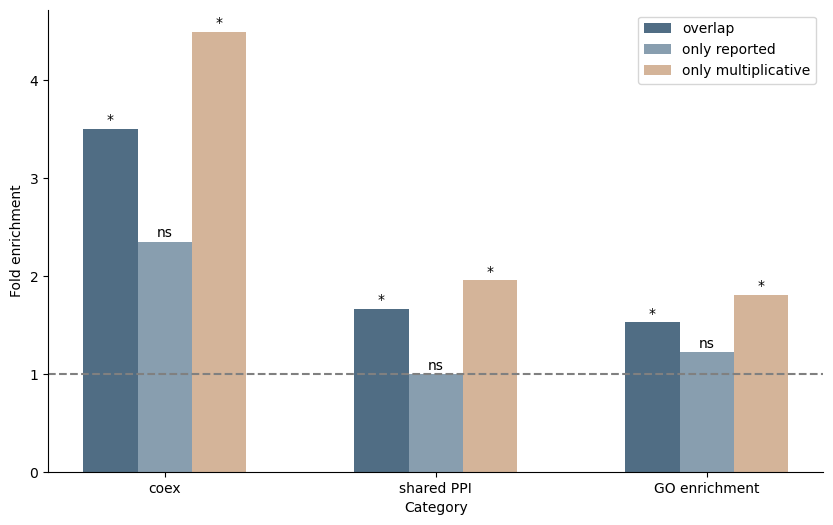

In [23]:
fig, axs = plt.subplots(figsize=(10,6))

# data: 
# rows are data category (overlap, only reported, only mult),
# cols are analysis (coex, PPI, GO)
x = np.arange(len(data1[0]))
width = 0.2

plt.bar(x-width, data1[0], width, color=overlap_color) # plots first analysis across all data categories (coex, PPI, GO)
plt.bar(x, data1[1], width, color=only_reported_color)
plt.bar(x+width, data1[2], width, color=only_mult_color)

plt.xticks(x, ['coex', 'shared PPI', 'GO enrichment'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["overlap", "only reported", "only multiplicative"])
#plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
sns.despine()

# add annotations for statistical significance
analyses = ["coex", "ppi", "go"]
for column in range(len(data1[0])):
    analysis = analyses[column]
    if dataset == "Kuzmin2020":
        # for 2020 data:
        # overlap and only_mult significant for all analyses, only_reported not significant for all analyses
        plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom')
        plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom')
        plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom')
    elif dataset == "Kuzmin2018":
        # for 2018 data:
        # overlap significant for all, only_mult significant only for GO and PPI, only_reported only significant for GO
        if analysis == "coex":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_mult  
        if analysis == "ppi":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom') # only_mult
        if analysis == "go":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom') # only_mult

plt.show()



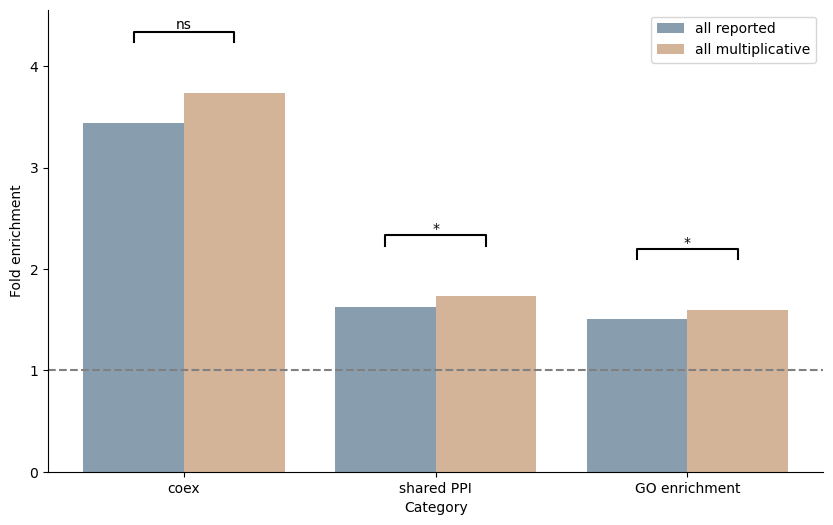

In [24]:
fig, axs = plt.subplots(figsize=(10,6))

# data: 
# rows are data category (overlap, only reported, only mult),
# cols are analysis (coex, PPI, GO)
x = np.arange(len(data2[0]))
width = 0.2

# plots first analysis across all data categories (coex, PPI, GO)
plt.bar(x-width, data2[0], width*2, color=only_reported_color)
plt.bar(x+width, data2[1], width*2, color=only_mult_color)

plt.xticks(x, ['coex', 'shared PPI', 'GO enrichment'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["all reported", "all multiplicative",])
#plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
sns.despine()


x1s = [-0.2, 0.8, 1.8]
x2s = [0.2, 1.2, 2.2]
addtl_height = 0.5
analyses = ["coex", "ppi", "go"]
for x1,x2,row in zip(x1s, x2s, x):
    analysis = analyses[row]
    y, h = np.max(data2[:,row]) + addtl_height, 0.1
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="black")
    # for 2020 data set, all_mult more significant for GO and PPI but not COEX
    if dataset == "Kuzmin2020":
        if analysis == "coex":
            plt.text((x1+x2)/2, y+h, "ns", ha='center', va='bottom', color="black")
        else:
            plt.text((x1+x2)/2, y+h, "*", ha='center', va='bottom', color="black")
    elif dataset == "Kuzmin2018":
        if analysis == "ppi":
            plt.text((x1+x2)/2, y+h, "*", ha='center', va='bottom', color="black")
        else:
            plt.text((x1+x2)/2, y+h, "ns", ha='center', va='bottom', color="black")
plt.show()



In [25]:
funcs =  enrich.alleles_2_go_enrichment
genome_wide = func(df)
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)

In [26]:
print(all_mult['frac']/genome_wide['frac'])
print(all_reported['frac']/genome_wide['frac'])

1.594731586440597
1.5106882804985513


In [27]:
print(all_mult['frac'])
print(all_reported['frac'])
print(genome_wide['frac'])
print(data2)

0.17224163754368446
0.1631644004944376
0.10800666332076841
[[3.4396214  1.62413442 1.51068828]
 [3.7402696  1.73145397 1.59473159]]


In [28]:
#tmp = df[(df.pval <= 0.05) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
overlap = df[(df.pval <= 0.05) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_mult = df[(df.pval <= 0.05) & (df.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_reported = df[(df.pval <= 0.05) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] > tau_mult_sig_val['neg'])]

print(len(overlap))
print(len(only_mult))
print(len(only_reported))


1527
476
91


genes in overlap: 881
min rand_samp: 1085
adding test_set: 939


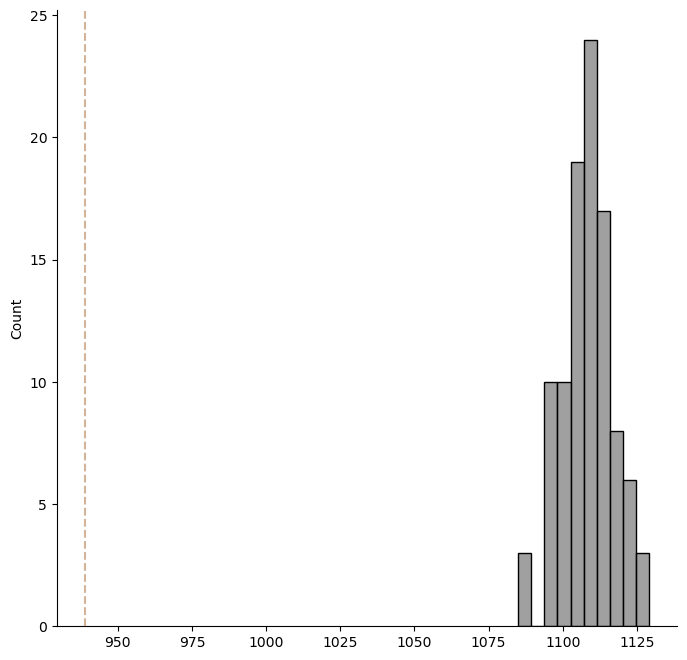

In [32]:
# COMPARES NUMBER OF GENE IN only_reported OR only_mult TO RANDOM
reps = 100

def unique_genes(df):
    genes = set()
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = [i.split('-')[0].upper() for i in a]
        [genes.add(i) for i in a]
    return genes

test_set = only_mult

overlap_unique_genes = unique_genes(overlap)
print("genes in overlap:", len(overlap_unique_genes))

genes_in_random_samples = []
for i in range(reps):
    tmp = overlap_unique_genes.copy()
    rand_samp = unique_genes(df.sample(n=len(test_set), replace=False))
    [tmp.add(i) for i in rand_samp]
    genes_in_random_samples.append( len(tmp) ) 
print("min rand_samp:", min(genes_in_random_samples))

tmp = overlap_unique_genes.copy()
[tmp.add(i) for i in unique_genes(test_set)]
print("adding test_set:", len(tmp))

pl = sns.histplot(genes_in_random_samples, bins=10, color="grey")
pl.axvline(len(tmp), linestyle="--", color=only_mult_color)
sns.despine()

912


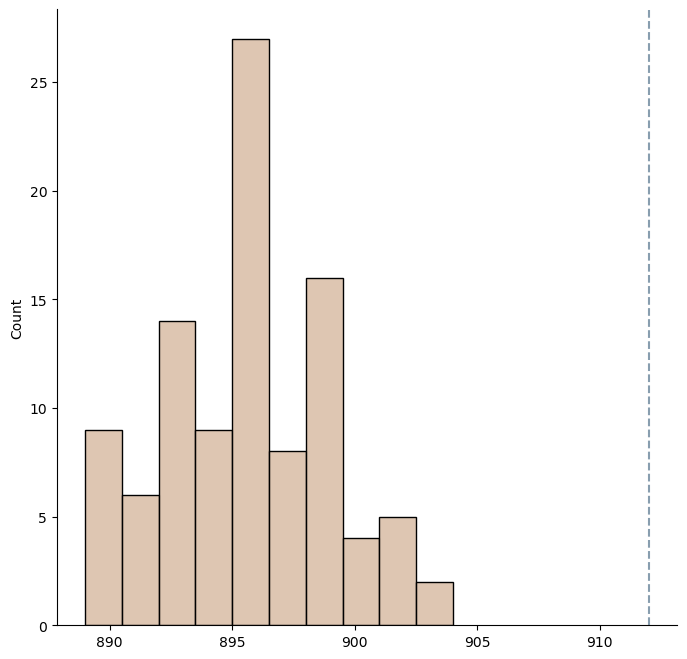

In [31]:
# COMPARES only_reported TO only_mult DIRECtlAY VIA SUBSAMPLING APPROACH

reported_unique_genes = overlap_unique_genes.copy()
[reported_unique_genes.add(i) for i in unique_genes(only_reported)]
print(len(reported_unique_genes))

# randomly subsample from only_mult
genes_in_random_samples = []
for i in range(reps):
    tmp = overlap_unique_genes.copy()
    rand_samp = unique_genes(only_mult.sample(n=len(only_reported), replace=False))
    [tmp.add(i) for i in rand_samp]
    genes_in_random_samples.append( len(tmp) ) 
#print("min rand_samp:", min(genes_in_random_samples))

pl = sns.histplot(genes_in_random_samples, bins=10, color=only_mult_color)
pl.axvline(len(reported_unique_genes), linestyle="--", color=only_reported_color)
sns.despine()


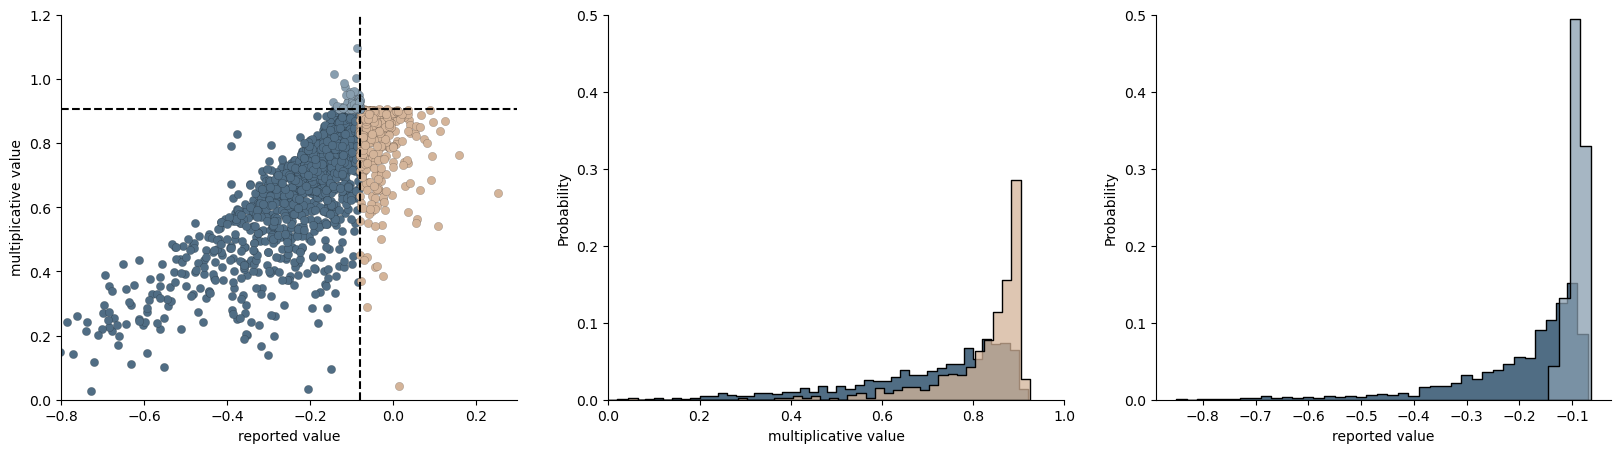

In [34]:

fig, axs = plt.subplots(ncols=3, figsize=(20,5))

alph = 1
lw = 0.1
bin_wid = 0.02
sns.scatterplot(x = overlap.adjusted_interaction_score_epsilon_or_tau,
                y=overlap[multiplicative],
                alpha=alph,
                linewidth=lw,
                edgecolor="black",
                color=overlap_color,
                ax=axs[0])
sns.scatterplot(x=only_mult.adjusted_interaction_score_epsilon_or_tau,
                y=only_mult[multiplicative],
                alpha=alph,
                linewidth=lw,
                edgecolor="black",               
                color=only_mult_color,
                ax=axs[0])
sns.scatterplot(x=only_reported.adjusted_interaction_score_epsilon_or_tau,
                y=only_reported[multiplicative],
                alpha=alph,
                linewidth=lw,
                edgecolor="black",
                color=only_reported_color,
                ax=axs[0])
axs[0].axvline(-0.08, linestyle="--", color="black")
axs[0].axhline(tau_mult_sig_val['neg'], linestyle="--", color="black")
axs[0].set(xlabel="reported value", ylabel='multiplicative value')


sns.despine()



sns.histplot(overlap, x=multiplicative, ax=axs[1], stat='probability', binwidth=bin_wid, color=overlap_color, element='step', edgecolor="black", alpha=1)
sns.histplot(only_mult, x=multiplicative, ax=axs[1], stat='probability', binwidth=bin_wid, color=only_mult_color, element='step', edgecolor="black")
axs[1].set(xlabel='multiplicative value')


sns.histplot(overlap, x='adjusted_interaction_score_epsilon_or_tau', ax=axs[2], stat='probability', binwidth=bin_wid, color=overlap_color, element='step', edgecolor="black", alpha=1)
sns.histplot(only_reported, x='adjusted_interaction_score_epsilon_or_tau', ax=axs[2], stat='probability', binwidth=bin_wid, color=only_reported_color, element='step', edgecolor="black")
axs[2].set(xlabel='reported value')

if dataset == "Kuzmin2018":
    axs[0].set_ylim(0,1.75)
    axs[0].set_xlim(-1.1,0.08)
    axs[1].set_ylim(0,0.4)
    axs[1].set_xlim(0,1.0)

    axs[2].set_ylim(0,0.4)

elif dataset == "Kuzmin2020":
    axs[0].set_ylim(0,1.2)
    axs[0].set_xlim(-0.8,0.3)
    axs[1].set_ylim(0,0.5)
    axs[1].set_xlim(0,1.0)

    axs[2].set_ylim(0,0.5)
#print(overlap[[multiplicative, compare]].corr(method="spearman"))
#print(overlap[[multiplicative, compare]].corr(method="kendall"))
#print(overlap[[multiplicative, compare]].corr(method="pearson"))

In [35]:
x = only_mult.alleles
y = only_reported.alleles

In [36]:
def genes_2_dict_of_tuples(df):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        genes[cnt] = a
        cnt += 1
    return genes

def genes_2_dict_of_tuples_subset(df, subset):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        if np.any([i in subset for i in a]):
            genes[cnt] = a
            cnt += 1
    return genes

def genes_2_edge_list(df):
    edges = [] # list of tuples
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        edges.extend([(a[0],a[1]), (a[0],a[2]), (a[1],a[2])])
    return edges

In [54]:

H_all = hnx.Hypergraph(genes_2_dict_of_tuples(pd.concat([overlap, only_mult, only_reported])))
H_overlap = hnx.Hypergraph(genes_2_dict_of_tuples(overlap))
H_mult = hnx.Hypergraph(genes_2_dict_of_tuples(pd.concat([overlap, only_mult])))


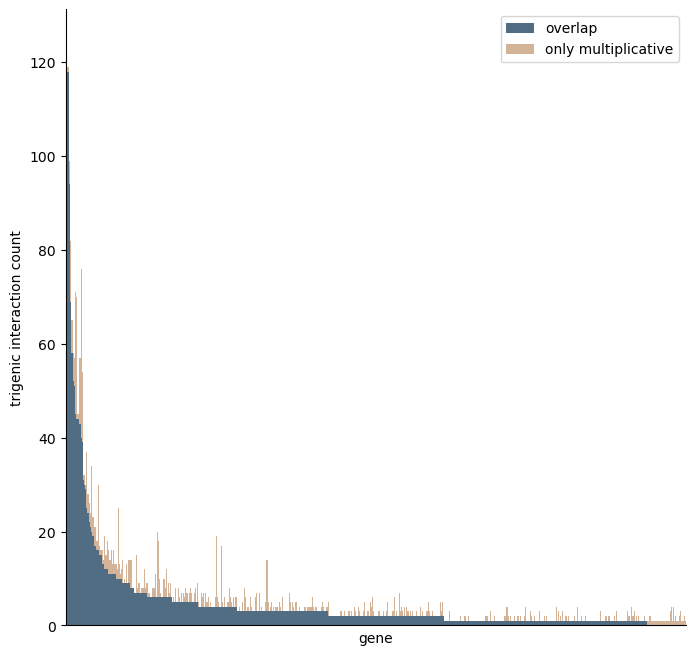

In [58]:
all_mult_genes = unique_genes(pd.concat([overlap, only_mult]))
overlap_genes = unique_genes(overlap)
only_mult_genes = unique_genes(only_mult)

# calculate the degree of each node in the overlap data and the all_mult data (overlap + only_mult)
d = defaultdict(list)
for gene in sorted(all_mult_genes):
    d['gene'].append(gene)
    # get degree just amongst overlap
    if gene in overlap_genes:
        d['overlap'].append(H_overlap.degree(gene))
    else:
        d['overlap'].append(0)
    d['all_mult_degree'].append(H_mult.degree(gene))

degrees = pd.DataFrame.from_dict(d)
degrees.loc[:, 'only multiplicative'] = degrees.all_mult_degree - degrees.overlap
degrees.loc[:, 'only multiplicative fraction'] = degrees['only multiplicative']/degrees.all_mult_degree
degrees = degrees.sort_values(by='overlap', ascending=False)

#tmp[['overlap', 'difference']][tmp.all_mult_degree > 10].plot.bar(stacked=True, color=["#a6cee3", "#b2df8a"], linewidth=0)
#tmp[['overlap', 'difference']][tmp.all_mult_degree > 20].plot.bar(stacked=True, color=["#a6cee3", "#b2df8a"], width=1, edgecolor="black")
pl = degrees[['overlap', 'only multiplicative']][degrees.all_mult_degree > 0].plot.bar(stacked=True, color=["#506D84", "#D4B499"], width=1)
pl.set_xlabel('gene')
pl.set_ylabel('trigenic interaction count')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    #which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#tmp[['overlap_degree', 'difference']][tmp.all_mult_degree > 0].plot.bar(stacked=True, width=1)
sns.despine()


In [63]:
tmp = degrees[degrees.all_mult_degree >= 5].sort_values(by='only multiplicative fraction', ascending=False)

In [ ]:
L = hmod.last_step(HG, K)

<AxesSubplot:ylabel='Count'>

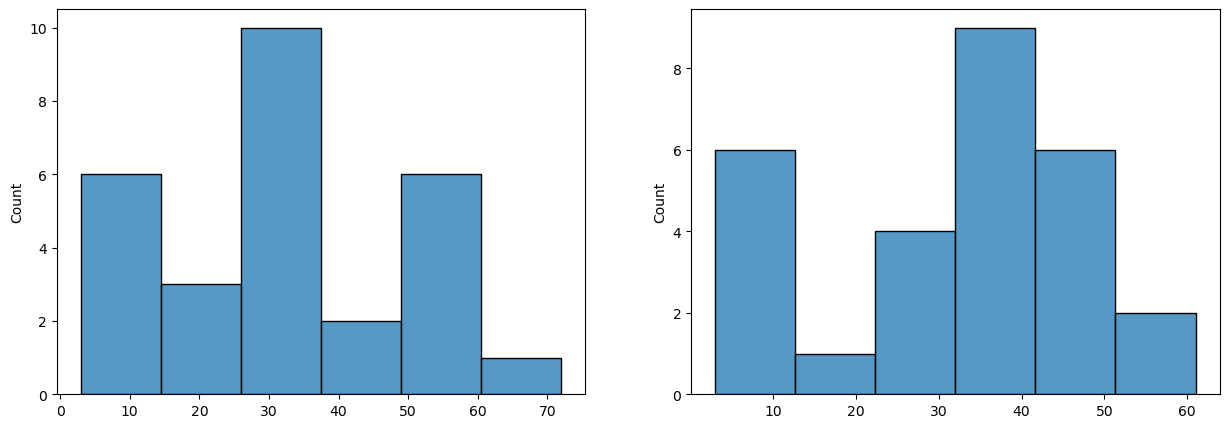

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

sns.histplot([len(i) for i in K], ax=axs[0])
sns.histplot([len(i) for i in L], ax=axs[1])